In [121]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint, solve_ivp
from scipy.signal import find_peaks
import os

In [122]:
MEDIA_PATH = 'media/assignment3'
os.makedirs(MEDIA_PATH, exist_ok=True)

Question 1: Complex calcium oscillations

In [127]:
# Declare parameters
#---------------------------------------
#Total concentrations (micro Moles)
Ca_tot =  90 
Pr_tot = 120

# Geometric Parameters

rho_ER = 0.01
rho_m = 0.01
beta_ER = 0.0025
beta_m = 0.0025

#Kinetics parameters

k_pump = 20 #s^-1
k_ch = 3900 #s^-1
k_leak = 0.05 #s^-1
k_in = 300 #(micro Moles s^-1)
k_out = 125 #s^-1
k_m = 0.00625 #s^-1
k_plus = 0.1 #(micro Moles)
k_minus = 0.01 #s^-1
K1 = 5 #(micro Moles)
K2 = 0.8 #(micro Moles)
K3 = 5 #(micro Moles)

#Initial concentrations (micro Moles)

Ca_cyt_0 = 0.3 
Ca_ER_0 = 0.2 
Ca_m_0 = 1 

In [128]:
def Ca_system(y, t, k_pump=k_pump, k_ch=k_ch, k_leak=k_leak, k_in=k_in, k_out=k_out, k_m=k_m, k_plus=k_plus, k_minus=k_minus, K1=K1, K2=K2, K3=K3, Ca_tot=Ca_tot, Pr_tot=Pr_tot, beta_ER=beta_ER, beta_m=beta_m, rho_ER=rho_ER, rho_m=rho_m):
    Ca_cyt, Ca_ER, Ca_m = y
    J_pump = k_pump*Ca_cyt
    J_ch = k_ch*((Ca_cyt**2)/(K1**2 + Ca_cyt**2))*(Ca_ER - Ca_cyt)
    J_leak = k_leak*(Ca_ER - Ca_cyt)
    J_in = k_in*(Ca_cyt**8)/(K2**8 + Ca_cyt**8)
    J_out = Ca_m*(((k_out*Ca_cyt**2) / (K3**2 + Ca_cyt**2))+k_m)
    CaPr = Ca_tot - Ca_cyt -(rho_ER/beta_ER)*Ca_ER - (rho_m/beta_m)*Ca_m
    Pr = Pr_tot - CaPr

    dCa_cyt = J_ch + J_leak - J_pump + J_out - J_in + k_minus*CaPr - k_plus*Ca_cyt*Pr
    dCa_ER = (beta_ER/rho_ER)*(J_pump - J_ch - J_leak)
    dCa_m = (beta_m/rho_m)*(J_in - J_out)
    
    return [dCa_cyt, dCa_ER, dCa_m]

def solve_system(t_span, y0, t_eval, system=Ca_system, method='LSODA', rtol=1e-10, atol=1e-10, **kwargs):
    final_system = lambda y, t: system(t, y, **kwargs)
    sol = solve_ivp(final_system, t_span, y0, method=method, t_eval=t_eval, rtol=rtol, atol=atol)
    return sol.t, sol.y

a) Describe the system on a molecular level.

**[Copy paste from paper]** The model system's main characteristics are three different calcium stores: the ER, mitochondria and calcium binding proteins in the cytosol. We focus on calcium exchange between the cytosol and the three calcium stores, neglecting any exchange of calcium between the cytosol and the extracellular space. Considering the ER, three different calcium ﬂuxes are included in the model: the ATP-dependent calcium uptake from the cytosol into the ER (Jpump ), the Ca 2+ efﬂux from the ER through channels following the calcium-induced calcium release (CICR) mechanism (Jch ) and an additional Ca 2+ leak ﬂux from the ER into the cytosol (Jleak ). For the exchange of Ca2+  between the mitochondria and the cytosol we take into account the following Ca 2+ ﬂuxes: active Ca 2+ uptake by mitochondrial uniporters (Jin ), calcium release through Na+ /Ca 2+ exchangers combined with a ﬂux through the mitochondrial permeability transition pores (PTPs) in a very low-conductance state, and a very small non-speciﬁc leak ﬂux (Jout ).

+most of relevant section in paper if we have space/time

b) Describe the model mathematically.

**[Copy paste from assignment / paper + some extra text from the paper section]**

c) Let us assume that due to a genetic mutation, the Ca 2+channel proteins are not transcribed and translated into a functional protein. How would you rewrite the equations of the model? What do you expect to happen?

In [129]:
def viz_system(t, y, filename):
    plt.figure(figsize=(8, 4), layout='tight')
    plt.plot(t, y[0], label='$[Ca_{cyt}]$')
    plt.plot(t, y[1], label='$[Ca_{ER}]$')
    plt.plot(t, y[2], label='$[Ca_m]$')
    plt.legend(loc='upper right')
    plt.xlabel('Time (t)')
    plt.ylabel('$[Ca]$')
    plt.grid()
    plt.title('Calcium concentration over time')
    plt.savefig(f'{MEDIA_PATH}/{filename}.png')
    plt.show()

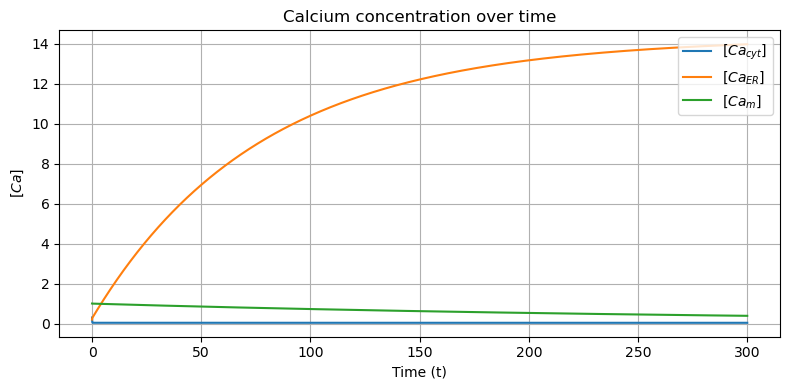

In [130]:
t_span = (0, 300)
t_eval = np.linspace(*t_span, 100_000) # very high resolution for phase plots
y0 = [Ca_cyt_0, Ca_ER_0, Ca_m_0]
t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=0)
Ca_cyt, Ca_ER, Ca_m = y[0], y[1], y[2]

viz_system(t, y, 'calcium_concentration_k_ch_0')

d) Use the conserved moieties to reduce the number variables in the set of ODEs to three independent variables.

**[Follow this section and plug back into the equations for variable reduction]**
In the present model, there are ﬁve variables: free cytosolic calcium concentration (Cacyt ), free calcium concentration in the ER (CaER ), free calcium concentration in mitochondria (Cam ), the concentration of free Ca 2+ binding sites on the cytosolic proteins (Pr) and the concentration of bounded Ca 2+ binding sites on the cytosolic proteins (CaPr). The number of model variables reduces to three independent variables applying the conservation relations for the total cellular calcium Catot ,

e) Build the model in python and plot the calcium concentrations in all three compartments over time ($t = 0 − 300$) for $k_{ch} = 3900s^{−1}$ using
$\{ Ca_{cyt}(0), Ca_{ER}(0), Ca_{m}(0) \} = \{ 0.3, 0.2, 1 \}$ as initial conditions.

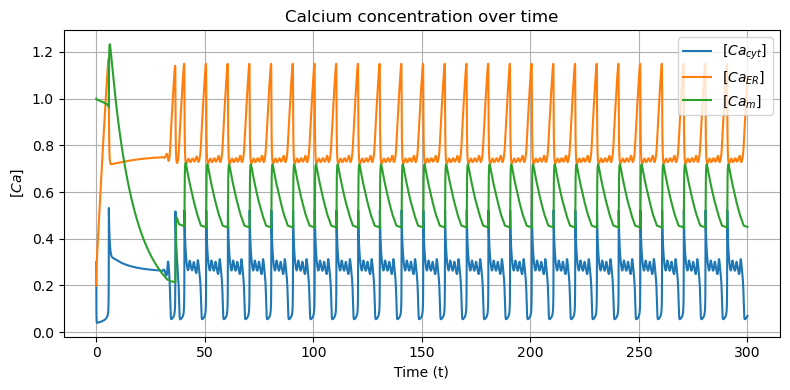

In [131]:
t_span = (0, 300)
t_eval = np.linspace(*t_span, 100_000) # very high resolution for phase plots
y0 = [Ca_cyt_0, Ca_ER_0, Ca_m_0]
t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval)
Ca_cyt, Ca_ER, Ca_m = y[0], y[1], y[2]

def viz_system(t, y, filename):
    plt.figure(figsize=(8, 4), layout='tight')
    plt.plot(t, y[0], label='$[Ca_{cyt}]$')
    plt.plot(t, y[1], label='$[Ca_{ER}]$')
    plt.plot(t, y[2], label='$[Ca_m]$')
    plt.legend(loc='upper right')
    plt.xlabel('Time (t)')
    plt.ylabel('$[Ca]$')
    plt.grid()
    plt.title('Calcium concentration over time')
    plt.savefig(f'{MEDIA_PATH}/{filename}.png')
    plt.show()

viz_system(t, y, 'calcium_concentration_1')

h) Create the three 2D-phase plots and analyse them. Identify any possible closed orbits and describe them.

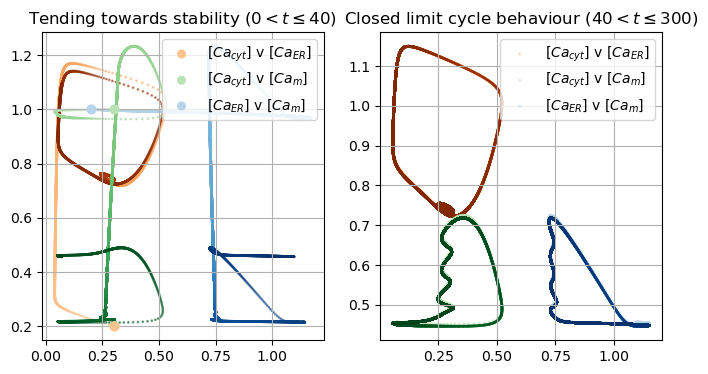

In [115]:
def viz_2d_phaseplots(t, y, ranges, titles, filename):
    '''Provided time series data of concentrations y, visualize 2D phase plots of all pairs of concentrations in subplots for each time range separately'''
    Ca_cyt, Ca_ER, Ca_m = y[0], y[1], y[2]
    fig = plt.figure(figsize=(8, 4))
    cmap_names = ['Oranges', 'Greens', 'Blues']
    # Reshapes cmaps to be offset and start at darker colors for visibility
    new_cmaps = [ListedColormap(plt.get_cmap(name)(np.linspace(0.3, 1, 256))) for name in cmap_names]
    pairs = [(Ca_cyt, Ca_ER), (Ca_cyt, Ca_m), (Ca_ER, Ca_m)]
    pair_names = ['$[Ca_{cyt}]$ v $[Ca_{ER}]$', '$[Ca_{cyt}]$ v $[Ca_m]$', '$[Ca_{ER}]$ v $[Ca_m]$']
    x_min = y_min = min([y_i.min() for y_i in y]) - 0.1
    x_max = y_max = max([y_i.max() for y_i in y]) + 0.1

    for i, (r_lower, r_upper) in enumerate(ranges):
        ax = fig.add_subplot(1, len(ranges), i+1)
        mask = (t >= r_lower) & (t < r_upper)
        t_range = t[mask]
        norm = Normalize(t_range.min(), t_range.max())
        for j, (pair, name) in enumerate(zip(pairs, pair_names)):
            cmap = new_cmaps[j]
            sc = ax.scatter(pair[0][mask], pair[1][mask], label=name, c=t[mask], cmap=cmap, s=1, norm=norm, alpha=0.5)
            # Plot starting points
            if i == 0:
                initial_color = cmap(norm(t[0]))
                ax.scatter(pair[0][0], pair[1][0], color=initial_color, s=40, zorder=10)
        legend = ax.legend(loc='upper right')
        ax.set_title(titles[i])

        # Increase the size of the legend markers
        for handle in legend.legend_handles:
            handle._sizes = [30]
            handle.set_alpha(1)
        ax.grid(True)
        
        # Set the same limits for all subplots
        # ax.set_xlim(x_min, x_max)
        # ax.set_ylim(y_min, y_max)

    plt.legend(loc='upper right')
    plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

ranges = [(0, 40), (40, 300)]
titles = [f'Tending towards stability (${ranges[0][0]} < t \\leq {ranges[0][1]}$)', f'Closed limit cycle behaviour (${ranges[1][0]} < t \\leq {ranges[1][1]}$)']
viz_2d_phaseplots(t, y, ranges, titles, '2d_phaseplots_1')

i) Create the 3D-phase plot and check if your conclusions in (g) still stand.

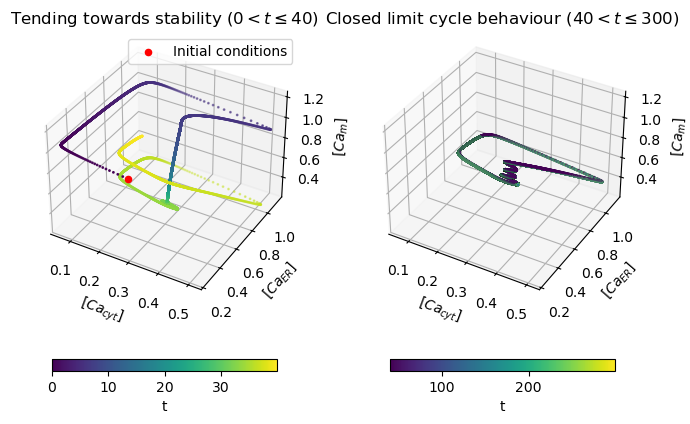

In [116]:
def viz_3d_phaseplots(t, y, ranges, titles, filename):
    '''Provided time series data of concentrations y, visualize 3D phase plots of the triplet of concentrations in subplots for each time range separately'''
    Ca_cyt, Ca_ER, Ca_m = y[0], y[1], y[2]
    fig = plt.figure(figsize=(8,5))
    cmap = 'viridis'

    for i, (r_lower, r_upper) in enumerate(ranges):
        ax = fig.add_subplot(1, len(ranges), i+1, projection='3d')
        mask = (t >= r_lower) & (t < r_upper)
        t_range = t[mask]
        norm = Normalize(t_range.min(), t_range.max())
        sc = ax.scatter(Ca_cyt[mask], Ca_ER[mask], Ca_m[mask], c=t[mask], cmap=cmap, s=1, norm=norm)
        if i == 0:
            ax.scatter(Ca_cyt_0, Ca_ER_0, Ca_m_0, c='r', s=20, label='Initial conditions')
            ax.legend()
        ax.set_xlabel('$[Ca_{cyt}]$')
        ax.set_ylabel('$[Ca_{ER}]$')
        ax.set_zlabel('$[Ca_m]$')
        ax.view_init(elev=35, azim=-60)
        ax.set_xlim(Ca_cyt.min(), Ca_cyt.max())
        ax.set_ylim(Ca_ER.min(), Ca_ER.max())
        ax.set_zlim(Ca_m.min(), Ca_m.max())
        ax.set_title(titles[i])
        fig.colorbar(sc, ax=ax, label='t', orientation='horizontal', shrink=0.8)

    plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

viz_3d_phaseplots(t, y, ranges, titles, '3d_phaseplots_1')

j) Now repeat the steps you took in (e) - (i) for $k_{ch} = 4000 s^{−1}$.

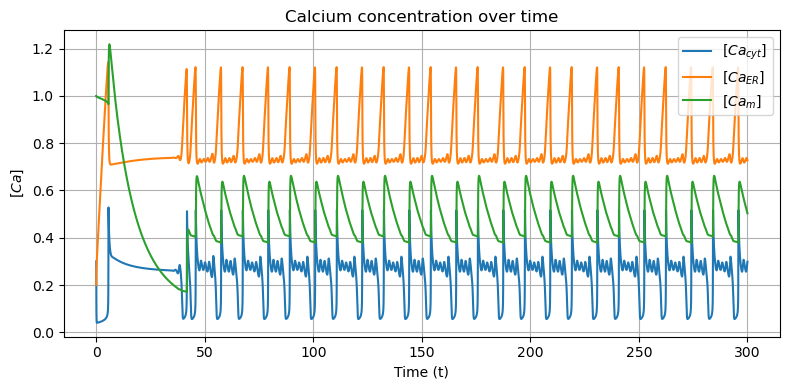

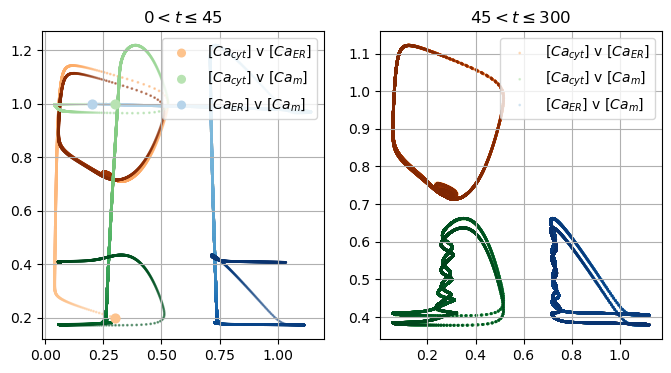

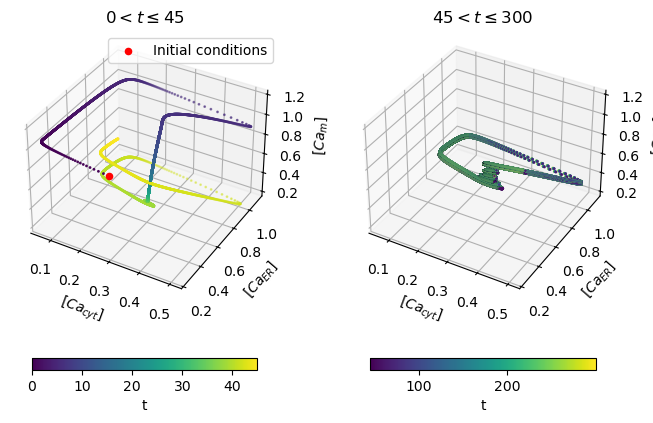

In [99]:
k_ch2 = 4000 # s^-1
t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=k_ch2)
viz_system(t, y, 'calcium_concentration_2')
ranges = [(0, 45), (45, 300)]
titles = [f'${range[0]} < t \\leq {range[1]}$' for range in ranges]
viz_2d_phaseplots(t, y, ranges, titles, '2d_phaseplots_2')
viz_3d_phaseplots(t, y, ranges, titles, '3d_phaseplots_2')

k) Now repeat the steps you took in (e) - (i) for $k_{ch} = 2830 s^{−1}$.

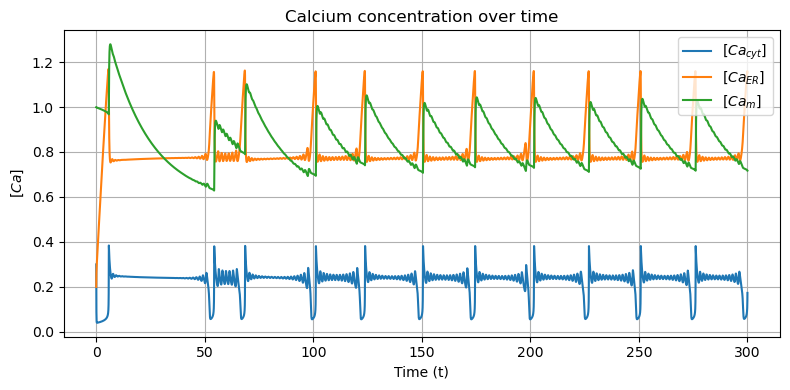

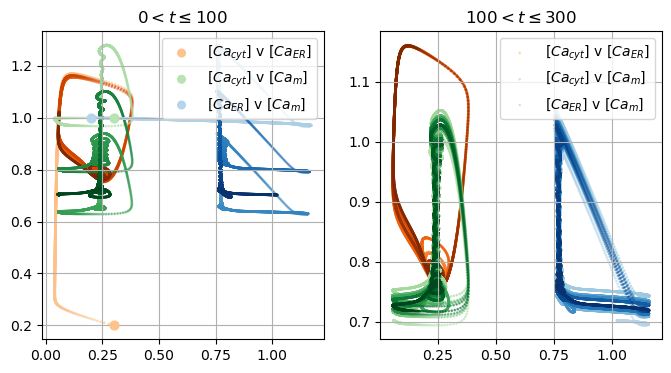

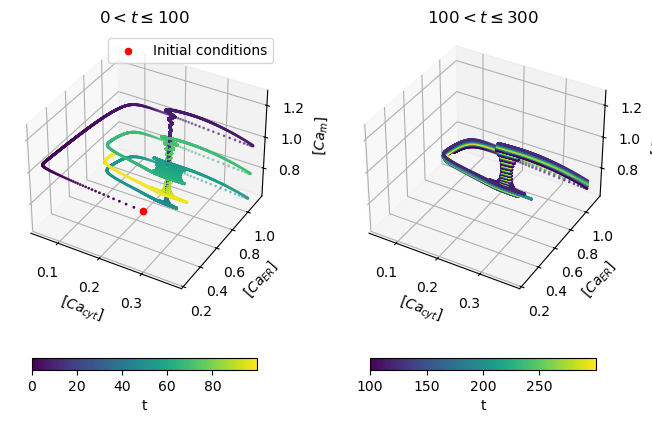

In [100]:
k_in3 = 2830 # s^-1
t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_in=k_in3)
viz_system(t, y, 'calcium_concentration_3')
ranges = [(0, 100), (100, 300)]
titles = [f'${range[0]} < t \\leq {range[1]}$' for range in ranges]
viz_2d_phaseplots(t, y, ranges, titles, '2d_phaseplots_3')
viz_3d_phaseplots(t, y, ranges, titles, '3d_phaseplots_3')

l) Create the Lorenz map based on the peaks in $Ca_m$ for the three values of $k_{ch}$ for $t = 100 - 1000$. Elaborate on your results. (Hint: The `ﬁnd_peaks` function might come in handy)

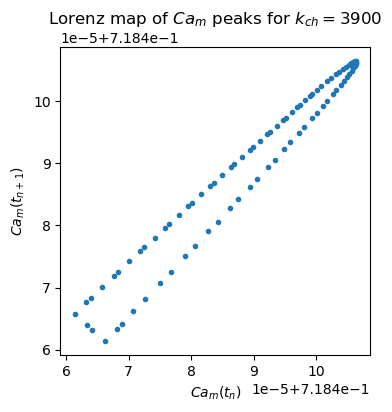

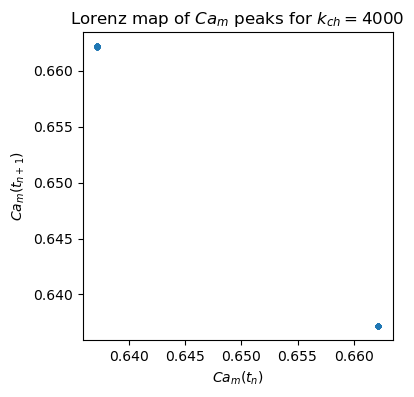

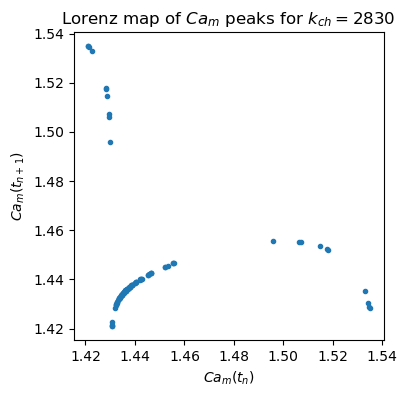

In [104]:
def get_peaks_of_Ca_m(t, Ca_m):
    peaks, _ = find_peaks(Ca_m, height=0.05)
    return t[peaks], Ca_m[peaks]

def lorenz_map(t, y, Ca_m_peaks, k_ch):
    Ca_m_peaks = Ca_m_peaks[1]
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(Ca_m_peaks[:-1], Ca_m_peaks[1:], 'o', markersize=3)
    ax.set_xlabel('$Ca_m(t_{n})$')
    ax.set_ylabel('$Ca_m(t_{n+1})$')
    ax.set_title(f'Lorenz map of $Ca_m$ peaks for $k_{{ch}} = {k_ch}$')
    plt.show()

k_chs = [3900, 4000, 2830]
t_span = (0, 1000)
t_eval = np.linspace(*t_span, 30_000)
t_range = (100, 1000)
mask = (t_eval >= t_range[0]) & (t_eval <= t_range[1])

for k_ch in k_chs:
    t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=k_ch)
    Ca_m = y[2]
    Ca_m_peaks = get_peaks_of_Ca_m(t[mask], Ca_m[mask])
    lorenz_map(t, y, Ca_m_peaks, k_ch=k_ch)

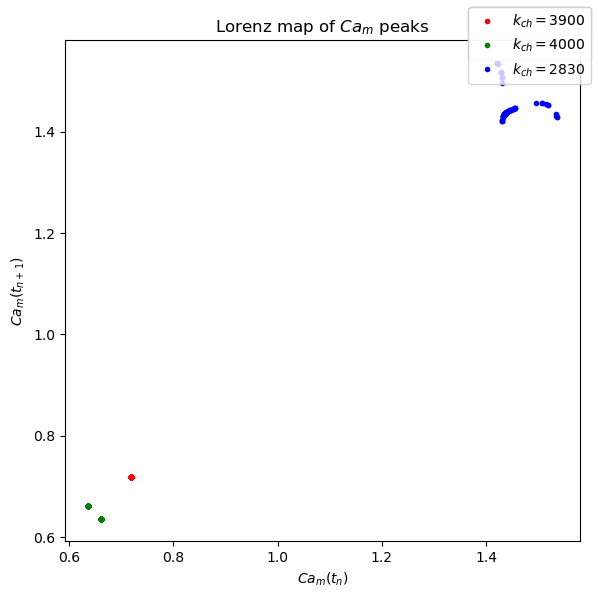

In [108]:
def lorenz_map(ax, t, y, Ca_m_peaks, k_ch, color):
    Ca_m_peaks = Ca_m_peaks[1]
    ax.plot(Ca_m_peaks[:-1], Ca_m_peaks[1:], 'o', markersize=3, color=color, label=f'$k_{{ch}} = {k_ch}$')
    ax.set_xlabel('$Ca_m(t_{n})$')
    ax.set_ylabel('$Ca_m(t_{n+1})$')
    ax.set_title(f'Lorenz map of $Ca_m$ peaks')

k_chs = [3900, 4000, 2830]
colors = ['red', 'green', 'blue']  # Define colors for each k_ch scenario
t_span = (0, 1000)
t_eval = np.linspace(*t_span, 30_000)
t_range = (100, 1000)
mask = (t_eval >= t_range[0]) & (t_eval <= t_range[1])

fig, ax = plt.subplots(figsize=(6, 6))  # Create a single subplot

for k_ch, color in zip(k_chs, colors):
    t, y = solve_system(t_span=t_span, y0=y0, t_eval=t_eval, k_ch=k_ch)
    Ca_m = y[2]
    Ca_m_peaks = get_peaks_of_Ca_m(t[mask], Ca_m[mask])
    lorenz_map(ax, t, y, Ca_m_peaks, k_ch=k_ch, color=color)
    fig.legend()

plt.tight_layout()
plt.show()

Question 2: Schnakenberg model

In [84]:
#Laplace 1D

def laplace_1D(X, dx):
    Xleft = np.roll(X, -1)
    Xright = np.roll(X, 1)
    return (Xleft + Xright - 2*X)/dx**2

In [85]:
def laplace_2D(X, dx):
    Xtop = np.roll(X, -1, axis=0)
    Xbottom = np.roll(X, 1, axis=0)
    Xleft = np.roll(X, -1, axis=1)
    Xright = np.roll(X, 1, axis=1)
    return (Xtop + Xbottom + Xleft + Xright - 4*X)/(dx**2)

In [86]:
def schnakenberg_model(u: np.ndarray, v: np.ndarray, Du, Dv, dx, c1, c2, c3, dim=1, **kwargs):
    laplace = None 
    if dim == 1:
        laplace = laplace_1D
    elif dim == 2:
        laplace = laplace_2D
    else:
        raise NotImplementedError('Only 1D and 2D models are supported')
    dUdt = Du * laplace(u, dx) + c1 - c1 * u + c3  * u**2 * v
    dVdt = Dv * laplace(v, dx) + c2 - c3 * u**2 * v
    return dUdt, dVdt

def solve_fwd_euler_1d(params: dict, model=schnakenberg_model):
    Nx, u0, v0 = params['Nx'], params['u0'], params['v0']
    dx, dt, T = params['dx'], params['dt'], params['T']

    u = np.empty(Nx)
    v = np.empty(Nx)
    u[...] = u0
    v[...] = v0

    for t in range(T):
        dudt, dvdt = model(u, v, dim=1, **params)
        u += dt * dudt
        v += dt * dvdt

    return u.reshape(1, Nx), v.reshape(1, Nx)

def solve_fwd_euler_2d(params: dict, model=schnakenberg_model):
    Nx, Ny, u0, v0 = params['Nx'], params['Ny'], params['u0'], params['v0']
    dx, dt, T = params['dx'], params['dt'], params['T']

    u = np.empty((Nx, Ny))
    v = np.empty((Nx, Ny))
    u[...] = u0
    v[...] = v0

    for t in range(T):
        dudt, dvdt = model(u, v, dim=2, **params)
        u += dt * dudt
        v += dt * dvdt

    return u, v

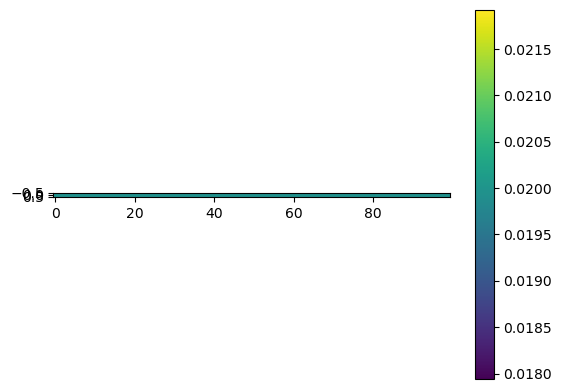

In [87]:
params = {'Nx': 100, 'Ny': 100, 'u0': 1, 'v0': 1, 'dx': 0.1, 'dt': 0.01, 'T': 1000, 'Du': 0.1, 'Dv': 0.1, 'c1': 0.1, 'c2': 0.9, 'c3': 0.9}
u, v = solve_fwd_euler_1d(params)
plt.imshow(u, cmap='viridis')
plt.imshow(v, cmap='viridis')
plt.colorbar()
plt.show()